# Comparison of t-test, bootstrap, permutation test output results

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
from mlxtend.evaluate import permutation_test

In [2]:
import string
import random

def get_random_alnum_str(length):
    letters_and_digits = string.ascii_letters + string.digits
    result_str = ''.join((random.choice(letters_and_digits) for i in range(length)))
    return result_str

## Generate the test set by running a power analysis

In [21]:
from scipy.stats import norm, zscore

def sample_power_difftest(d: float, s: float, power: float=0.8, sig: float=0.05) -> float:
    z = norm.isf([sig / 2])
    zp = -1 * norm.isf([power])
    n = s * ((zp + z)**2) / (d**2)
    return n.round(0)

In [47]:
effect_size_array = np.arange(0.01, 0.15, 0.005)

cohens_d = effect_size_array * generated_data['metric'].mean() / generated_data['metric'].std()
per_bucket_n = sample_power_difftest(cohens_d, 2)

In [48]:
min_bucket_size = 0.5
buckets = 2
sample_df = pd.DataFrame(effect_size_array, columns=["effect_size"])
data = generated_data.query("iteration == 1")['metric']
sample_df["num_users"] = len(data)
sample_df["min_users_needed_in_smallest_bucket"] = per_bucket_n
sample_df["detectable"] = (len(data) * min_bucket_size > per_bucket_n) & \
                          (len(data) > per_bucket_n * buckets)

In [49]:
sample_df

,effect_size,num_users,min_users_needed_in_smallest_bucket,detectable
0,0.010,2000,14448.0,False
1,0.015,2000,6421.0,False
2,0.020,2000,3612.0,False
3,0.025,2000,2312.0,False
4,0.030,2000,1605.0,False
5,0.035,2000,1179.0,False
6,0.040,2000,903.0,True
7,0.045,2000,713.0,True
8,0.050,2000,578.0,True
9,0.055,2000,478.0,True


In [17]:
es = (100 - 105) / 40 # calculating an effect size M_1 - M_2 / SD_polled 
es

-0.125

In [18]:
import statsmodels.stats.api as sms
sms.TTestIndPower().solve_power(effect_size=es, power=0.8, nobs1=None, ratio=1, alpha=0.05)

1005.6154263659035

In [3]:
# Generate synthetic data
def generate_data(n=1000, mean=100, delta=5, sd=40, iterations=1000):
    norm1 = np.random.normal(loc=mean, scale=sd, size=n*iterations)
    norm2 = np.random.normal(loc=mean+delta, scale=sd, size=n*iterations)
    iter_list = [i//n + 1 for i in range(iterations*n)]
    
    norm1_df = pd.DataFrame({'subject_id': [get_random_alnum_str(16) for i in range(iterations*n)],
                             'experiment_group': ['control' for i in range(iterations*n)],
                             'metric': norm1,
                             'iteration': iter_list})
    norm2_df = pd.DataFrame({'subject_id': [get_random_alnum_str(16) for i in range(iterations*n)],
                             'experiment_group': ['treatment' for i in range(iterations*n)],
                             'metric': norm2,
                             'iteration': iter_list})

    combined_df = norm1_df.append(norm2_df)

    return combined_df

In [4]:
generated_data = generate_data(sd=31)

In [10]:
generated_data

,subject_id,experiment_group,metric,iteration
0,hVod7dLrM2e14Tzp,control,111.869974,1
1,c9ndKogyzXqNnVe8,control,87.889825,1
2,k0AP4VERjyXbaK51,control,119.615202,1
3,QiJerQ1siTVr0sCO,control,115.205353,1
4,n9qwbmbKdEyndHky,control,95.601374,1
...,...,...,...,...
999995,WtMrl9SMN0WOOViK,treatment,111.018555,1000
999996,5K4sheERYTiwpHzZ,treatment,132.520019,1000
999997,Gb2eQiixHUzpexMj,treatment,89.845103,1000
999998,MroHNFCoXJx4VIWg,treatment,100.116606,1000


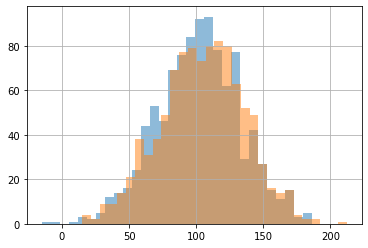

In [95]:
it = np.random.randint(1,1000)
generated_data.query("experiment_group == 'control' & iteration == @it")['metric'].hist(bins=30, alpha=.5)
generated_data.query("experiment_group == 'treatment' & iteration == @it")['metric'].hist(bins=30, alpha=.5);

In [34]:
def run_tests(data):
    iterations = data.iteration.unique()
    t_pvalues = np.zeros(iterations.shape)
    b_lowers = np.zeros(iterations.shape)
    b_uppers = np.zeros(iterations.shape)
    perm_pvalues = np.zeros(iterations.shape)

    for i in iterations:
        control = data.loc[(data['experiment_group'] == 'control') & (data['iteration'] == i), 'metric']
        treatment = data.loc[(data['experiment_group'] == 'treatment') & (data['iteration'] == i), 'metric']
        # run t-test
        _, t_pvalue = stats.ttest_ind(treatment, control, equal_var=False)
        t_pvalues[i-1] = t_pvalue

        # run bootstrap
        b = bs.bootstrap_ab(treatment.to_numpy(),
                            control.to_numpy(),
                            bs_stats.mean,
                            bs_compare.percent_change, # (test_stat - ctrl_stat) / ctrl_stat * 100
                            num_iterations=1000)
        b_lowers[i-1] = b.lower_bound
        b_uppers[i-1] = b.upper_bound

        # run permutation test
        perm_pvalue = permutation_test(treatment.to_numpy(), control.to_numpy(),
                                       method='approximate', num_rounds=1000, seed=0)
        perm_pvalues[i-1] = perm_pvalue

    results = pd.DataFrame({'iteration': iterations,
                            't_test_p_value': t_pvalues,
                            'bootstrap_lower': b_lowers,
                            'bootstrap_upper': b_uppers,
                            'perm_test_p_value': perm_pvalues
                           })
    results['t_test_sig'] = (results.t_test_p_value < 0.05).astype('int')
    results['bootstrap_sig'] = (results.bootstrap_lower > 0).astype('int')
    results['perm_test_sig'] = (results.perm_test_p_value < 0.05).astype('int')

    return results

In [35]:
results_df = run_tests(generated_data)

In [36]:
results_df

,iteration,t_test_p_value,bootstrap_lower,bootstrap_upper,perm_test_p_value,t_test_sig,bootstrap_sig,perm_test_sig
0,1,0.000266,2.267958,8.064992,0.001998,1,1,1
1,2,0.000002,3.682873,9.390375,0.000999,1,1,1
2,3,0.000092,2.631692,8.207522,0.000999,1,1,1
3,4,0.024011,0.307010,6.074444,0.014985,1,1,1
4,5,0.000951,1.747378,7.135463,0.002997,1,1,1
...,...,...,...,...,...,...,...,...
995,996,0.008969,0.967068,6.356559,0.005994,1,1,1
996,997,0.000390,2.132653,7.474928,0.000999,1,1,1
997,998,0.000157,2.576882,8.166442,0.000999,1,1,1
998,999,0.000006,3.616302,9.406029,0.000999,1,1,1


In [37]:
results_df[['t_test_sig', 'bootstrap_sig', 'perm_test_sig']].mean()

t_test_sig       0.960
bootstrap_sig    0.951
perm_test_sig    0.959
dtype: float64

In [35]:
generated_data.to_csv('~/Downloads/tests_python_data.csv', index=False)

## PyMC3
Here we use PyMC3 to do Bayesian modeling on our data set. Can we fit a model and find parameters that explain the data we see? Probably. The more operative question is whether PyMC3 can handle data the size of the set we have here.

In [56]:
# Let's try sub-sampling first to see if it works on 100k points
x_control = generated_data.loc[generated_data.experiment_group == 'control','metric'].sample(60000)
x_variant = generated_data.loc[generated_data.experiment_group == 'treatment', 'metric'].sample(60000)

In [6]:
from pymc3 import sample, Uniform, StudentT, Normal, Exponential, Deterministic, Model

with Model() as cpr_model:
    
    μ_control = Normal('μ_control', 10, sd=100)
    μ_variant = Normal('μ_variant', 10, sd=100)
    
    σ_control = Uniform('σ_control', lower=0, upper=1000)
    σ_variant = Uniform('σ_variant', lower=0, upper=1000)
    
    #ν = Exponential('ν_minus_one', 1/29.) + 1
    
    #control_like = StudentT('control_like', nu=ν, mu=μ_control, lam=σ_control**-2, observed=x_control)
    #variant_like = StudentT('variant_like', nu=ν, mu=μ_variant, lam=σ_variant**-2, observed=x_variant)
    
    control_like = Normal('control_like', mu=μ_control, sd=σ_control, observed=x_control)
    variant_like = Normal('variant_like', mu=μ_variant, sd=σ_variant, observed=x_variant)
    
    diff_of_means = Deterministic('difference of means', μ_variant - μ_control)
    
    effect_size = Deterministic('effect size', 
                        diff_of_means / np.sqrt((σ_variant**2 + σ_control**2) / 2))

In [7]:
with cpr_model:
    cpr_sample = sample(1000, return_inferencedata=False)

<ipython-input-7-b8866e2a0965>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  cpr_sample = sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_variant, σ_control, μ_variant, μ_control]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 102 seconds.


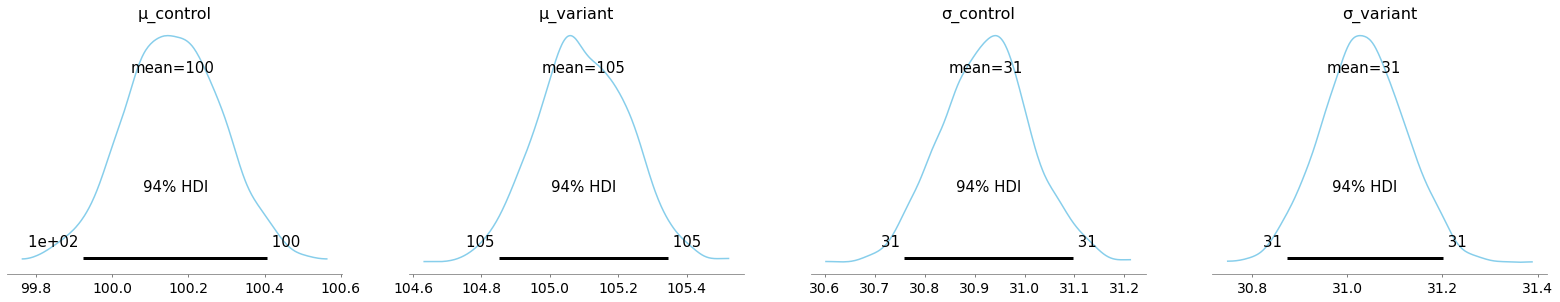

In [11]:
from pymc3 import plot_posterior

with cpr_model:
    plot_posterior(cpr_sample, 
                   var_names=['μ_control', 'μ_variant',
                              'σ_control', 'σ_variant'],
                   color='#87ceeb');

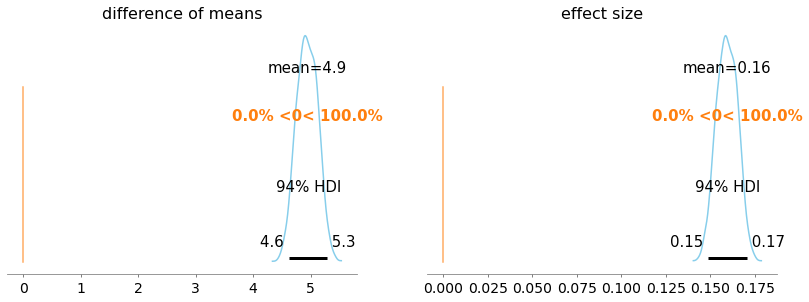

In [12]:
with cpr_model:
    plot_posterior(cpr_sample,
                   var_names=['difference of means', 'effect size'],
                   ref_val=0,
                   color='#87ceeb');